In [15]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import statistics
import math


In [2]:
df = pd.read_csv('heart.csv')
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
5,58,0,0,100,248,0,0,122,0,1.0,1,0,2,1
6,58,1,0,114,318,0,2,140,0,4.4,0,3,1,0
7,55,1,0,160,289,0,0,145,1,0.8,1,1,3,0
8,46,1,0,120,249,0,0,144,0,0.8,2,0,3,0
9,54,1,0,122,286,0,0,116,1,3.2,1,2,2,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [4]:
# check missing data
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

<AxesSubplot:>

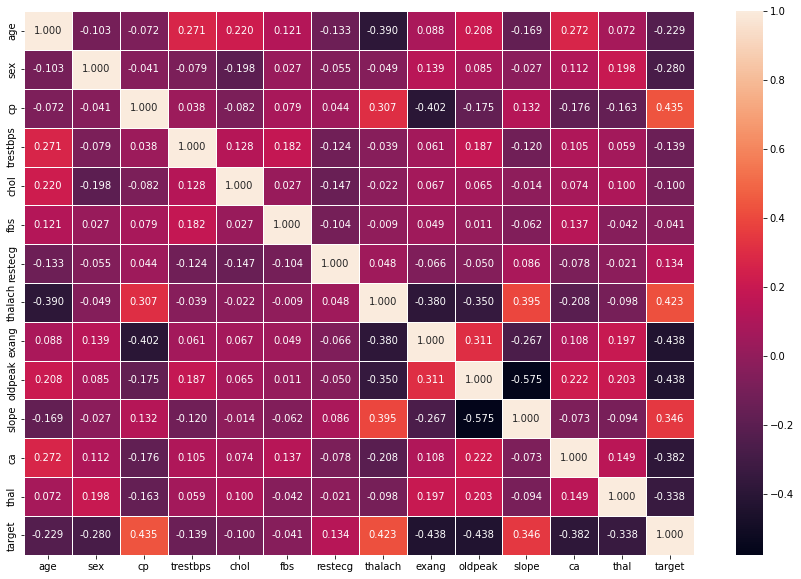

In [5]:
# VISUALIZATIONS
# Correlation Heatmap confirms what found with the pairplot
cor_mat=df.corr()
fig,ax=plt.subplots(figsize=(15,10))
sns.heatmap(cor_mat,annot=True,linewidths=0.5,fmt=".3f")

In [6]:
# Splitting the data into features and labels

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
# Creating an instance of the Naive Bayes classifier
clf = GaussianNB()
# Training the model on the training data
clf.fit(X_train, y_train)
# Predicting the labels for the test data
y_pred = clf.predict(X_test)
# Creating a confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Calculating the accuracy of the model
print("Naive Bayes Model Accuracy: ", clf.score(X_test, y_test))

Naive Bayes Model Accuracy:  0.814935064935065


#### ROC curve

In [8]:
train_probs = clf.predict_proba(X_train)[:,1]
test_probs = clf.predict_proba(X_test)[:,1]
fpr_train, tpr_train, _ = roc_curve(y_train, train_probs)
fpr_test, tpr_test, _ = roc_curve(y_test, test_probs)
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)


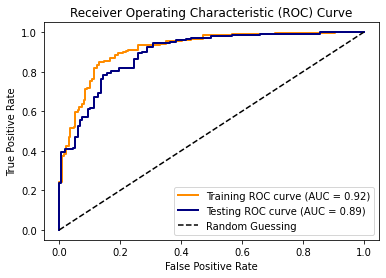

In [9]:
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='Training ROC curve (AUC = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='navy', lw=2, label='Testing ROC curve (AUC = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

#### Hyperparameter Tuning of Smoothing Paramter 

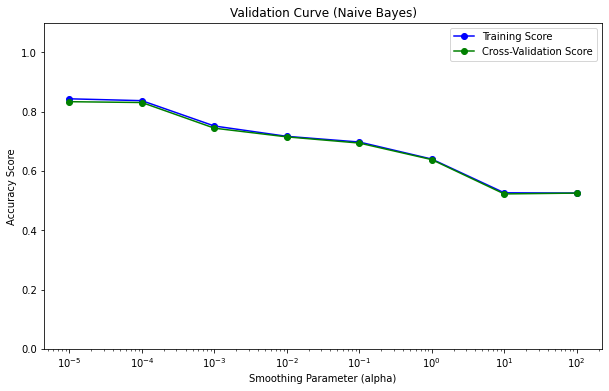

In [10]:
alpha_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
# Compute the learning curve for each alpha value
train_scores, test_scores = validation_curve(
    GaussianNB(),
    X_train,
    y_train,
    param_name='var_smoothing',
    param_range=alpha_list,
    cv=5,
    scoring='accuracy'
)

# Calculate the mean and standard deviation of the training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Compute the mean and standard deviation of the train and test scores
plt.figure(figsize=(10, 6))
plt.title('Validation Curve (Naive Bayes)')
plt.xlabel('Smoothing Parameter (alpha)')
plt.ylabel('Accuracy Score')
plt.ylim(0.0, 1.1)
plt.semilogx(alpha_list, train_mean, label='Training Score', color='blue', marker='o')
plt.semilogx(alpha_list, test_mean, label='Cross-Validation Score', color='green', marker='o')
plt.legend(loc='best')
plt.show()

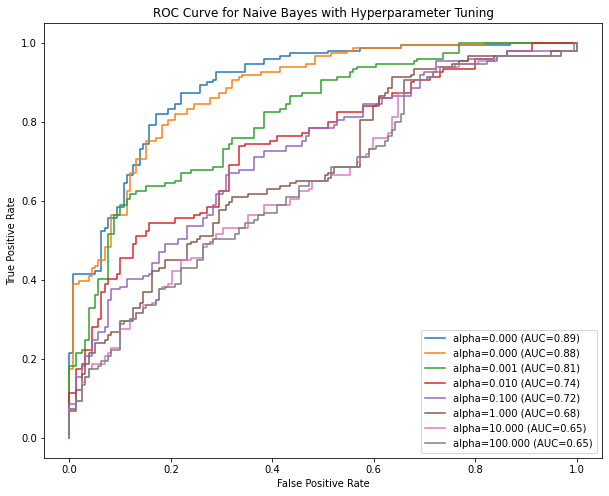

In [11]:
alpha_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

plt.figure(figsize=(10, 8))
for alpha in alpha_list:
    # train Naive Bayes model with current alpha value
    clf = GaussianNB(var_smoothing=alpha)
    clf.fit(X_train, y_train)
    
    # predict probabilities and calculate ROC curve
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # plot ROC curve
    plt.plot(fpr, tpr, label='alpha={:.3f} (AUC={:.2f})'.format(alpha, roc_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Naive Bayes with Hyperparameter Tuning')
plt.legend()
plt.show()


In [12]:
param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}
grid_search = GridSearchCV(clf, param_grid, cv=10, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Get the best alpha value and ROC AUC score
best_alpha = grid_search.best_params_['var_smoothing']
best_score = grid_search.best_score_

print("Best hyperparameters:", best_alpha)
print("The auc score is", best_score)

Best hyperparameters: 1.2328467394420658e-05
The auc score is 0.9109279558195968


#### Hyperparameter Tuning of Feature Selection

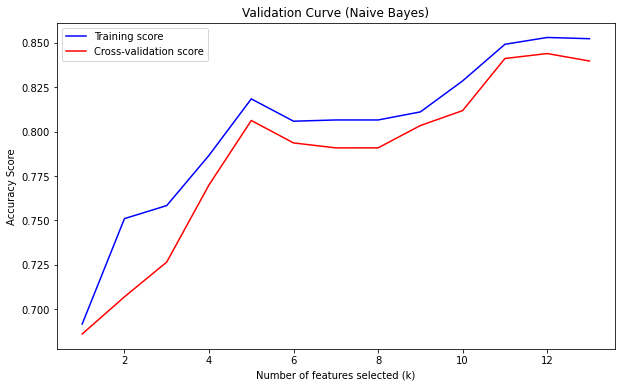

In [13]:
k_values = list(range(1, len(X_train.columns)+1))
# create the pipeline
pipe = make_pipeline(
    SelectKBest(chi2),
    GaussianNB()
)
# Compute the learning curve for each alpha value

train_scores, test_scores = validation_curve(
    pipe,
    X_train,
    y_train,
    param_name='selectkbest__k',
    param_range=k_values,
    cv=5,
    scoring='accuracy'
)

# Calculate the mean and standard deviation of the training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# plot the learning curve
plt.figure(figsize=(10, 6))
plt.title('Validation Curve (Naive Bayes)')
plt.xlabel('Number of features selected (k)')
plt.ylabel('Accuracy Score')
plt.plot(k_values, train_mean, label='Training score', color='blue')
plt.plot(k_values, test_mean, label='Cross-validation score', color='red')
plt.legend(loc='best')
plt.show()

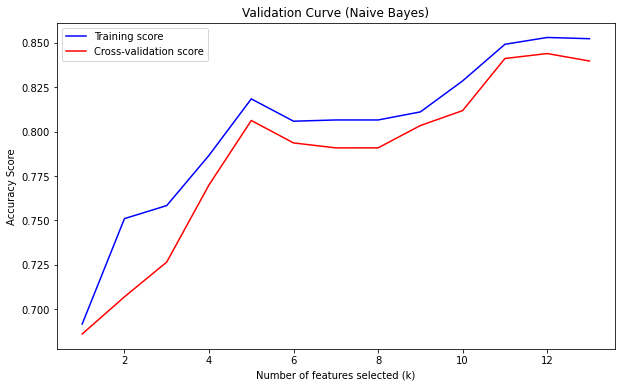

In [24]:
k_values = list(range(1, len(X_train.columns)+1))
# create the pipeline
pipe = make_pipeline(
    SelectKBest(chi2),
    GaussianNB()
)
# Compute the learning curve for each alpha value

train_scores, test_scores = validation_curve(
    pipe,
    X_train,
    y_train,
    param_name='selectkbest__k',
    param_range=k_values,
    cv=5,
    scoring='accuracy'
)

# Calculate the mean and standard deviation of the training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
bias = 1 - np.mean(train_scores, axis=1)
variance = np.var(test_scores, axis=1)
# plot the learning curve
plt.figure(figsize=(10, 6))
plt.title('Validation Curve (Naive Bayes)')
plt.xlabel('Number of features selected (k)')
plt.ylabel('Accuracy Score')
plt.plot(k_values, train_mean, label='Training score', color='blue')
plt.plot(k_values, test_mean, label='Cross-validation score', color='red')
plt.legend(loc='best')
plt.show()



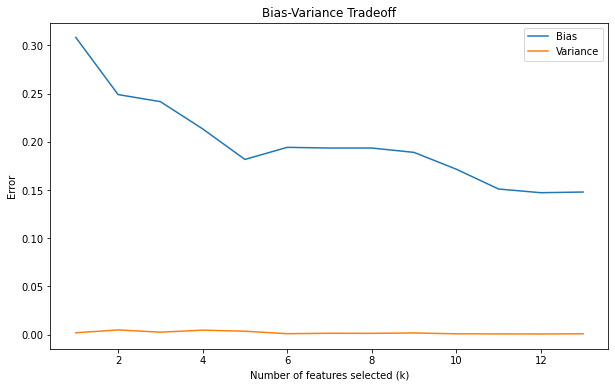

In [25]:
plt.figure(figsize=(10, 6))

plt.plot(k_values, bias, label='Bias')
plt.plot(k_values, variance, label='Variance')

plt.title('Bias-Variance Tradeoff')
plt.xlabel('Number of features selected (k)')
plt.ylabel('Error')
plt.legend(loc='best')
plt.show()

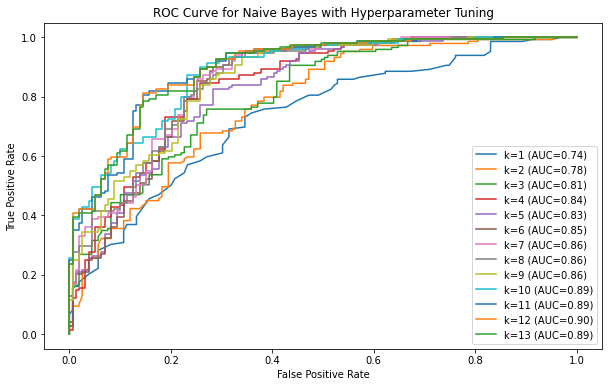

In [28]:
plt.figure(figsize=(10, 6))
k_values = list(range(1, len(X_train.columns)+1))
for k in k_values:
    # Select top k features using chi-squared test
    selector = SelectKBest(score_func=chi2, k=k)
    X_train_new = selector.fit_transform(X_train, y_train)
    X_test_new = selector.transform(X_test)
    
    # Train Naive Bayes classifier with selected features
    clf = GaussianNB()
    clf.fit(X_train_new, y_train)
    
    # Compute ROC curve and AUC on test set
    fpr, tpr, threshold = roc_curve(y_test, clf.predict_proba(X_test_new)[:,1])
    roc_auc = auc(fpr, tpr)
    
    # plot ROC curve
    plt.plot(fpr, tpr, label='k={:} (AUC={:.2f})'.format(k, roc_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Naive Bayes with Hyperparameter Tuning')
plt.legend()

plt.show()
